In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.tri as tri
   


In [2]:
rc['legend.fontsize']=18
rc['axes.titlesize']=18
rc['lines.linewidth']=1.5
rc['lines.markersize']=8
rc['font.size']=18
rc['legend.handletextpad']= 0.2
rc['legend.frameon']=False
rc['text.usetex']=True
#print(rc.keys)

In [3]:
def tau_p(p1,k1,Nn):
    g=0.1
    return g*Nn**2/(np.pi**2*k1*p1**2)

In [4]:
def fit_func(x,a,b,c,d,e,f,g):
    return d*np.exp(-a*x)*(np.cos(b*x+c)+np.sin(f*x+g))+e

100
0.0 5.0 0.0
0.0 5.0 0.1
2.0 5.0 0.1
10.0 5.0 0.1
20.0 5.0 1.0
200.0 5.0 1.0
1000.0 5.0 1.0
41 0


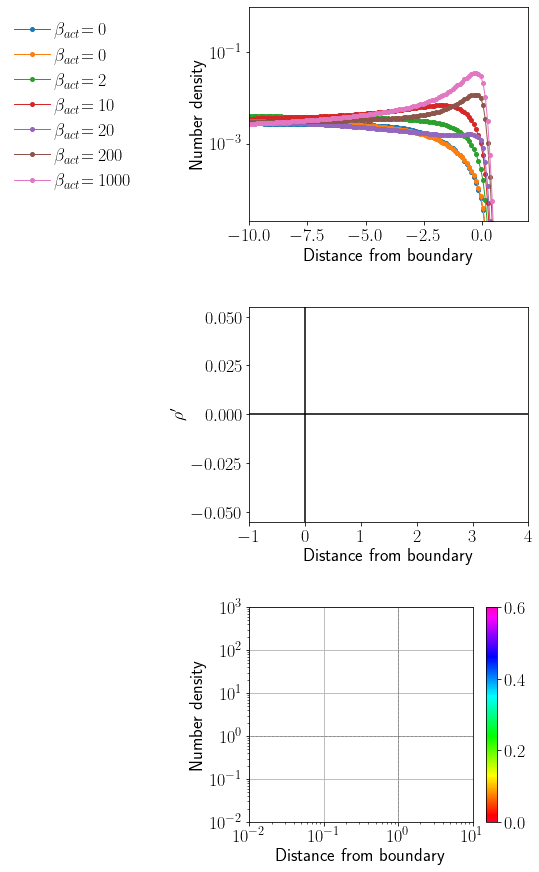

In [64]:
fig,axes=plt.subplots(3,1,figsize=(5,15),gridspec_kw={'wspace':0.4, 'hspace':0.4})

# [[ax1,ax2],[ax3,ax4]]=axes
[ax1,ax3,ax4]=axes
ind=4
nvals=[300,100]

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
X,Y,Z=[],[],[]
w=0
for jj,fpath in enumerate(['../data/ROUSE_chain_confined_Ns/N300/','../../data/ROUSE_chain_confined_Ns/']):
    nn=nvals[jj]
    if jj==0: continue

    print(nn)
    for fname in os.listdir(fpath):
        if '.npz' in fname and 'RDPs' in fname:
            # print(fname)#.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            if dt!=0.001: 
                print(dt)
                continue
            # if kb!=5: continue
            # print(tau_p(1,kb,nn),kb,nn)
            # if 0.5<Ta/tau_p(1,kb,nn)<1.5: c='g'
            t1=tau_p(1,kb,nn)
            r=T+F**2*Ta*t1**2/(0.1*(t1**2-Ta**2))
            tr=Ta/t1
            if tr>1: c='b'
            if tr<=1: 
                c='r'
                # continue
            w+=1
            b_act=np.around(F**2*Ta/(0.1*T),decimals=0)
            # if b_act not in [0.0, 2.0,40.0, 160.0, 180.0]: continue
            # if T==0.5 and F==0.1 and (Ta==10 or Ta==50) and R0==10 and (kb==5 ) and nn==100:
            if R0==100 and T==0.5 and kb==5:
                npzfile=np.load(fpath+fname)
                print(b_act, kb,F,)
                if F==0.008: continue
                bin_w=R0/npzfile['bins'].shape[0]
                # if Ta>t1: continue
                
                ax1.plot(npzfile['bins']-R0,npzfile['hist'][0], '.-',label='$\\beta_{act}$'+'$={:.0f} $'.format(b_act,),lw=1)
        
                
                # drho=-np.gradient(npzfile['hist'][0])/(np.gradient(npzfile['bins']))
                
                # drho=np.array([xx/max(drho) for xx,yy in zip(drho,npzfile['bins'])  if yy<R0+1 and yy>R0-4])
                

                # drho_bins=np.array([R0-xx for xx in npzfile['bins'] if xx<R0+1 and xx>R0-4])
                # p,pcov=curve_fit(fit_func,drho_bins,drho)
                # print(p)
                # if np.any(drho<0):cval=-min(drho)
                # else: cval=0

                # ax3.plot(drho_bins, drho, '.-',lw=0.5)
                # ax4.loglog(Ta/t1,F**2*Ta/(0.1*T),'o',c=m.to_rgba(cval))
                # ax3.plot(np.linspace(0,10,50), fit_func(np.linspace(0,10,50), p[0],p[1],p[2],p[3],p[4]),'k--',lw=0.5)
                # ax1.set_title('$T={}\ F={}$'.format(T,F))
                # Y.append(F**2*Ta/(0.1*T))
                # X.append(Ta/t1)
                # Z.append(cval)
                
                # print('{:.2f}'.format(Ta/t1), cval)
                # ax1.set_xlim(-1,R0+1)
                # ax1.plot(npzfile['bins']/R0,npzfile['hist'][0], '-',label='Equilibrium')
            
            # if Ta/tau_p(1,kb,nn)>1:
            #     ax3.plot(npzfile['bins']/R0, npzfile['hist'][0])
            
            # if Ta/tau_p(1,kb,nn)<1:
            #     ax4.plot(npzfile['bins']/R0, npzfile['hist'][0])
            
            if False:
                npzfile=np.load(fpath+fname)
                bin_w=R0/npzfile['bins'].shape[0]
                ax2.plot(npzfile['bins']/R0,npzfile['hist'][0], '-',label='$F={}$ $\\tau_a={:.1f}\ (\\tau_1={:.0f})$'.format(F,Ta,t1))
                ax4.plot(npzfile['bins']/R0, -np.gradient(npzfile['hist'][0]/(np.gradient(npzfile['bins']))))
            
print(w,len(X))
for axi in axes.flatten():
    # handles, labels = axi.get_legend_handles_labels()
    # #print(labels)
    # hl = sorted(zip(handles, labels),
    #         key=lambda x: float(x[1].split('=')[1].replace('$','')))
    # handles2, labels2 = zip(*hl)
    # #print(labels2)
    # axi.legend(handles2, labels2,)
    # axi.legend(loc='lower left',bbox_to_anchor=(1.1,0.1))
    axi.set_yscale('log')
    # axi.set_xscale('log')
    # axi.grid(True)
    # axi.set_xlim([-1,6])
    
    axi.set_xlabel('Distance from boundary')
    axi.set_ylabel('Number density')
ax3.set_yscale('Linear')
# ax4.set_yscale('SymLog')
ax1.legend(loc='upper left', ncol=1,bbox_to_anchor=(-0.9,1))
ax3.set_ylabel('$\\rho^\\prime$')

ax4.set_xscale('Log')
ax4.set_yscale('Log')
ax4.set_xlim(1e-2,10)
ax4.set_ylim(1e-2,1e3)

ax1.set_ylim([2e-5,1])
ax1.set_xlim([-10,2])


ax3.set_xlim([-1,4])
ax3.axvline(0,c='k')
# ax4.set_yscale('Linear')
# ax4.set_xlim([-2,5])
# ax4.axhline(0,c='k')
ax3.axhline(0,c='k')
# ax4.set_xlim([0.9,1.02])
# ax4.set_xlim([1e-2,2e1])
ax4.axhline(1,c='k',ls=':',lw=0.5)
ax4.axvline(1,c='k',ls=':',lw=0.5)
ax4.grid()
plt.colorbar(m)

fig.savefig('../../plots/Rouse/RC_RDP_R0100.png', dpi=300, bbox_inches='tight')


Text(0, 0.5, '$F^2\\tau_a/(\\gamma T)$')

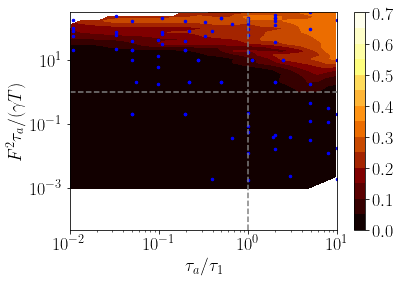

In [598]:
Xi,Yi=np.meshgrid(np.logspace(-3,2,50),np.logspace(-3,4,60))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,Z)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.linspace(0,0.7,15),cmap='afmhot')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)


plt.plot(X,Y,'.',c='b',markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,10)
plt.ylim(5e-5,3e2)
plt.axhline(1,c='0.5',ls='--',)
plt.axvline(1,c='0.5',ls='--',)

# plt.grid(True,alpha=0.5,which='both')

plt.colorbar()
plt.xlabel('$\\tau_a/\\tau_1$')
plt.ylabel('$F^2\\tau_a/(\gamma T)$')
# plt.savefig('../plots/Rouse/RC_RDP_phase_diag.png',dpi=300, bbox_inches='tight')

#confined_N300 and _N100_new

In [545]:
f=0.003
T=0.8
Ta=350
t1=tau_p(1,5,300)
print('{:.1f} {:.3f} {:.3f}'.format(t1, Ta/t1,f**2*Ta/(0.02*T)))


182.4 1.919 0.197
